# Preliminary Experiments with Existing Algorithms

Preliminary experiment consists of three algorithms: learning fair representations (pre-processing), adversarial debiasing (in-processing), and calibrayed equalized odds (post-processing). In order to compare these algorithms, Adult census and German credit datasets will be used. Logistic regression classifier will be used to train and test the results

In [1]:
#importing the required libraries
import sys
sys.path.insert(1, "../")  

import numpy as np

#datasets
from aif360.datasets import AdultDataset, GermanDataset
#functions to pre-process datasets 
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german

#metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector


#algorithms
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.algorithms.preprocessing.lfr import LFR

#progress meter for algorithms
from tqdm import tqdm


#scalers & classifiers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

#markdown and plotting
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import warnings; warnings.simplefilter('ignore')

In [2]:
#importing the datassets

#Adult
adult_orig = load_preproc_data_adult()
adult_orig_train, adult_orig_test = adult_orig.split([0.7], shuffle=True)

a_privileged_groups = [{'sex': 1.0}]
a_unprivileged_groups = [{'sex': 0.0}]

#German credit
german_orig = GermanDataset(
    protected_attribute_names=['age'],          
    privileged_classes=[lambda x: x >= 25],
    # ignore sex-related attributes in order to focus on single binary sensitive attribute
    features_to_drop=['personal_status', 'sex']
)

german_orig.labels

array([[1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],

In [3]:
for i in range(1000):
    if (german_orig.labels[i] == 2.):
        german_orig.labels[i] = 0
    else:
        german_orig.labels[i] = 1
        
german_orig.favorable_label = 1
german_orig.unfavorable_label = 0

german_orig_train, german_orig_test = german_orig.split([0.7], shuffle=True)

g_privileged_groups = [{'age': 1}]
g_unprivileged_groups = [{'age': 0}]



In [4]:
german_orig.labels

array([[1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],

In [5]:
#It finda that German dataset has a class imbalance, 700 positive and 300 negative outcomes.
k=0
for i in range(1000):
    if(german_orig.labels[i] == 1):
        k+=1
    else:
        pass
print(k)

700


In [6]:
# some information of each dataset regarding labels, names, etc. 
display(Markdown("#### German Training Dataset shape"))
print(german_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(german_orig_train.favorable_label, german_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(german_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(german_orig_train.privileged_protected_attributes, 
      german_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(german_orig_train.feature_names)

display(Markdown("#### Adult Training Dataset shape"))
print(adult_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(adult_orig_train.favorable_label, adult_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(adult_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(adult_orig_train.privileged_protected_attributes, 
      adult_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(adult_orig_train.feature_names)

#### German Training Dataset shape

(700, 57)


#### Favorable and unfavorable labels

1 0


#### Protected attribute names

['age']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192', 'foreign_wor

#### Adult Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [7]:
adult_orig_train

               instance weights            features                       \
                                protected attribute                        
                                               race  sex Age (decade)=10   
instance names                                                             
36846                       1.0                 1.0  1.0             0.0   
17099                       1.0                 1.0  1.0             0.0   
22225                       1.0                 1.0  1.0             0.0   
27858                       1.0                 1.0  1.0             0.0   
2199                        1.0                 1.0  1.0             0.0   
...                         ...                 ...  ...             ...   
17876                       1.0                 1.0  1.0             0.0   
26648                       1.0                 1.0  1.0             0.0   
40135                       1.0                 1.0  1.0             0.0   
40043       

In [8]:
german_orig_train

               instance weights features                \
                                                         
                                   month credit_amount   
instance names                                           
718                         1.0     24.0        3148.0   
471                         1.0      6.0         448.0   
765                         1.0     12.0        1155.0   
353                         1.0     12.0        6199.0   
709                         1.0      9.0        2118.0   
...                         ...      ...           ...   
234                         1.0      4.0        1544.0   
202                         1.0     27.0        5117.0   
776                         1.0     36.0        3535.0   
181                         1.0     36.0        4455.0   
300                         1.0      6.0         672.0   

                                                                \
                                                               

In [9]:
# Initial disparities in the original datasets

#Adult
metric_ad_orig_train = BinaryLabelDatasetMetric(adult_orig_train, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)
display(Markdown("#### Adult original training dataset"))

print("Disparate impact (of original labels) between unprivileged and privileged groups = %f" % metric_ad_orig_train.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_ad_orig_train.statistical_parity_difference())
print("Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = %f" % metric_ad_orig_train.consistency())

metric_ad_orig_test = BinaryLabelDatasetMetric(adult_orig_test, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)
display(Markdown("#### Adult original test dataset"))

print("Disparate impact (of original labels) between unprivileged and privileged groups = %f" % metric_ad_orig_test.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_ad_orig_test.statistical_parity_difference())
print("Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = %f" % metric_ad_orig_test.consistency())

#------------------------------------------------------------------

#German
metric_ger_orig_train = BinaryLabelDatasetMetric(german_orig_train, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)
display(Markdown("#### German original training dataset"))

print("Disparate impact ratio (of original labels) between unprivileged and privileged groups = %f" % metric_ger_orig_train.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_ger_orig_train.statistical_parity_difference())
print("Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = %f" % metric_ger_orig_train.consistency())

metric_ger_orig_test = BinaryLabelDatasetMetric(german_orig_test, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)
display(Markdown("#### German original test dataset"))

print("Disparate impact ratio (of original labels) between unprivileged and privileged groups = %f" % metric_ger_orig_test.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_ger_orig_test.statistical_parity_difference())
print("Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = %f" % metric_ger_orig_test.consistency())

#n_neighbors warning exists due to how this individual metric is implemented in the library. The function has its own parameter n_neighbors=5

#### Adult original training dataset

Disparate impact (of original labels) between unprivileged and privileged groups = 0.349001
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.198855
Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = 0.739776


#### Adult original test dataset

Disparate impact (of original labels) between unprivileged and privileged groups = 0.384917
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.184405
Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = 0.738948


#### German original training dataset

Disparate impact ratio (of original labels) between unprivileged and privileged groups = 0.782540
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.153501
Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = 0.666286


#### German original test dataset

Disparate impact ratio (of original labels) between unprivileged and privileged groups = 0.909091
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.068182
Individual fairness metric from Zemel et.al. that measures how similar the labels are for similar instances = 0.730000


### Initial fairness performance of the predictions of a classifier without mitigation

In [10]:
#Scaling the dataset
scale_orig = StandardScaler()

#German
X_train_g = scale_orig.fit_transform(german_orig_train.features)
X_test_g = scale_orig.transform(german_orig_test.features)

y_train_g = german_orig_train.labels.ravel()
y_test_g = german_orig_test.labels.ravel()

#Adult
X_train_a = scale_orig.fit_transform(adult_orig_train.features)
X_test_a = scale_orig.transform(adult_orig_test.features)

y_train_a = adult_orig_train.labels.ravel()
y_test_a = adult_orig_test.labels.ravel()


#Logistic Regression Training for each dataset
log_reg_g = LogisticRegression(class_weight='balanced', solver='liblinear') 
log_reg_a = LogisticRegression(class_weight='balanced', solver='liblinear') 

#Fitting the German dataset
log_reg_g.fit(X_train_g, y_train_g)

#Fitting Adult dataset
log_reg_a.fit(X_train_a, y_train_a)

#Predicting test set labels
y_test_pred_g = log_reg_g.predict(X_test_g)
y_test_pred_proba_g = log_reg_g.predict_proba(X_test_g)

y_test_pred_a = log_reg_a.predict(X_test_a)
y_test_pred_proba_a = log_reg_a.predict_proba(X_test_a)


In [11]:
print(y_test_pred_g)

[0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.]


### Fairness Performance of the predicted labels

In [12]:
#1) German Dataset

display(Markdown("#### German Test Set Fairness Performance Results"))

#Create a new version of the test set with predicted class labels
g_testset_pred = german_orig_test.copy()
g_testset_pred.labels = y_test_pred_g

#Construction 1
#to construct this metric function, the predicted labels should be united with the test fetures to make a new datas
metric_ger_pred_test = BinaryLabelDatasetMetric(g_testset_pred, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)

#Construction 2
#both original test dataset with actual labels and the test dataset combined with predicted class labels need to be given to this function
classified_metric_g = ClassificationMetric(german_orig_test, 
                                                 g_testset_pred,
                                                 unprivileged_groups=g_unprivileged_groups,
                                                 privileged_groups=g_privileged_groups)


#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
aeo_g = classified_metric_g.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % aeo_g)

#Disparate Impact ratio between privileged and unprivileged groups.
di_g = classified_metric_g.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % di_g)

#Demographic parity difference between privileged and unprivileged groups.
spd_g = classified_metric_g.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % spd_g)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
ppd_g = classified_metric_g.positive_predictive_value(privileged=False) - classified_metric_g.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % ppd_g)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_ger_pred_test.consistency())



#2) Adult Dataset
display(Markdown("#### Adult Test Set Fairness Performance Results"))

a_testset_pred = adult_orig_test.copy()
a_testset_pred.labels = y_test_pred_a

#Construction 1
#to construct this metric function, the predicted labels should be united with the test fetures to make a new datas
metric_ad_pred_test = BinaryLabelDatasetMetric(a_testset_pred, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)


#Construction 2
#both original test dataset and the test dataset with predicted class labels need to be given to this function
classified_metric_a = ClassificationMetric(adult_orig_test, 
                                                 a_testset_pred,
                                                 unprivileged_groups=a_unprivileged_groups,
                                                 privileged_groups=a_privileged_groups)

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
aeo_a = classified_metric_a.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % aeo_a)

#Disparate Impact ratio between privileged and unprivileged groups.
di_a = classified_metric_a.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % di_a)

#Demographic parity difference between privileged and unprivileged groups.
spd_a = classified_metric_a.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % spd_a)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
ppd_a = classified_metric_a.positive_predictive_value(privileged=False) - classified_metric_a.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % ppd_a)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_ad_pred_test.consistency())


#### German Test Set Fairness Performance Results

Average equalized odds difference between unprivileged and privileged groups = -0.207217
Disparate impact ratio between unprivileged and privileged groups = 0.599449
Demographic parity difference between unprivileged and privileged groups = -0.258168
Predictive Parity difference between unprivileged and privileged groups = -0.002496
Consistency of indivuals' predicted labels = 0.638667


#### Adult Test Set Fairness Performance Results

Average equalized odds difference between unprivileged and privileged groups = -0.309830
Disparate impact ratio between unprivileged and privileged groups = 0.303623
Demographic parity difference between unprivileged and privileged groups = -0.354631
Predictive Parity difference between unprivileged and privileged groups = -0.137221
Consistency of indivuals' predicted labels = 0.999126


### Classifier Performance Metrics Before Debiasing

In [13]:
#German

TPRg = classified_metric_g.true_positive_rate() #recall
TNRg = classified_metric_g.true_negative_rate() #specificity
PPVg = classified_metric_g.positive_predictive_value() #precision
bal_acc_g = (TPRg+TNRg)/2
f1_g = 2*((PPVg*TPRg)/(PPVg+TPRg))

display(Markdown("#### Classifier Prediction Performance on German Test Set"))
print("Standard accuracy of logistic regression trained on German dataset without any mitigation = %f" % classified_metric_g.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset without any mitigation = %f" % bal_acc_g)
print("F1 score of logistic regression trained on German dataset without any mitigation = %f" % f1_g)


#Adult

TPRa = classified_metric_a.true_positive_rate()
TNRa = classified_metric_a.true_negative_rate()
PPVa = classified_metric_a.positive_predictive_value()
bal_acc_a = (TPRa+TNRa)/2
f1_a = 2*((PPVa*TPRa)/(PPVa+TPRa))

display(Markdown("#### Classifier Prediction Performance on Adult Test Set "))
print("Standard accuracy of logistic regression trained on German dataset without any mitigation = %f" % classified_metric_a.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset without any mitigation = %f" % bal_acc_a)
print("F1 score of logistic regression trained on German dataset without any mitigation = %f" % f1_a)


#### Classifier Prediction Performance on German Test Set

Standard accuracy of logistic regression trained on German dataset without any mitigation = 0.726667
Balanced accuracy of logistic regression trained on German dataset without any mitigation = 0.727997
F1 score of logistic regression trained on German dataset without any mitigation = 0.797030


#### Classifier Prediction Performance on Adult Test Set 

Standard accuracy of logistic regression trained on German dataset without any mitigation = 0.730567
Balanced accuracy of logistic regression trained on German dataset without any mitigation = 0.739181
F1 score of logistic regression trained on German dataset without any mitigation = 0.572264


[[ 57  21]
 [ 61 161]]


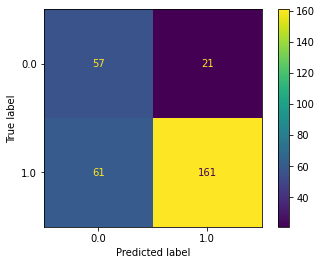

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_german = confusion_matrix(german_orig_test.labels, g_testset_pred.labels)

disp_german = ConfusionMatrixDisplay(confusion_matrix=cm_german,
                              display_labels=log_reg_g.classes_)
disp_german.plot() 
print(cm_german)

[[8064 3094]
 [ 854 2641]]


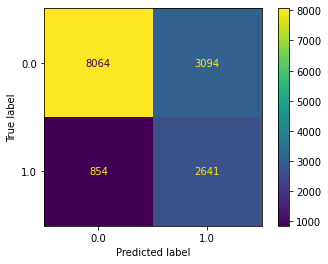

In [15]:
cm_adult = confusion_matrix(adult_orig_test.labels, a_testset_pred.labels)

disp_adult = ConfusionMatrixDisplay(confusion_matrix=cm_adult,
                              display_labels=log_reg_a.classes_)
disp_adult.plot() 
print(cm_adult)

## Implementation of the Mitigation Algorithms

### Pre-processing algorithm: Learning Fair Representations

In [16]:
#1) Transforming Adult Dataset

#Required Inputs:
# Input recontruction quality - Ax
# Fairness constraint - Az
# Output prediction error - Ay

#scaled dataset together with its labels is needed
adult_orig_train.features = scale_orig.fit_transform(adult_orig_train.features)
adult_orig_test.features = scale_orig.transform(adult_orig_test.features)

#LFR itself contains logistic regression sinc it uses signoid functions 
LFR_a =LFR(unprivileged_groups=a_unprivileged_groups,
         privileged_groups=a_privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR_a = LFR_a.fit(adult_orig_train, maxiter=5000, maxfun=5000)


# Transform training data and align features
a_transf_train = TR_a.transform(adult_orig_train)
a_transf_test = TR_a.transform(adult_orig_test)


250 90306.36003896409
500 80078.5328275418
750 79120.46611630426
1000 77046.55851525687
1250 74577.57813132436
1500 70275.22338106718
1750 68694.4809387689
2000 69503.3259307258
2250 72486.29062741545
2500 66275.8441892547
2750 65021.28609418889
3000 64091.14101906252
3250 63320.85375665051
3500 62165.80127457388
3750 61493.348339243385
4000 60327.36163417848
4250 59671.09415112863
4500 59380.55507053173
4750 59075.49481090723
5000 58302.25508954917


In [17]:
#2) Transforming German Dataset

#scaled dataset together with its labels is needed
german_orig_train.features = scale_orig.fit_transform(german_orig_train.features)
german_orig_test.features = scale_orig.transform(german_orig_test.features)

#LFR itself contains logistic regression sinc it uses signoid functions 
LFR_g =LFR(unprivileged_groups=g_unprivileged_groups,
         privileged_groups=g_privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR_g = LFR_g.fit(german_orig_train, maxiter=5000, maxfun=5000)


# Transform training data and align features
g_transf_train = TR_g.transform(german_orig_train)
g_transf_test = TR_g.transform(german_orig_test)


5250 5174.340256982482
5500 5174.340204508332
5750 5174.34020742048
6000 4933.20266266008
6250 4933.202669127981
6500 4933.202689967512
6750 4367.433633185673
7000 4367.433626513126
7250 4367.43382716014
7500 4486.82089127534
7750 4486.820880235935
8000 4486.821021105483
8250 4269.803911780465
8500 4269.803904453566
8750 4252.427878845078
9000 4252.427894885917
9250 4252.427927193267
9500 4222.301270607914
9750 4222.301278707445
10000 4222.301273083467
10250 4141.5158664988285
10500 4141.5157374169485
10750 4141.515928131614
11000 4147.616583238368
11250 4147.616576100433


### Performance Evaluation of LFR algorithm

#### Fairness performance of the datasets before classification

In [18]:
#Fairness Performance of Datasets Before Classification

#Constucting two functions to call the desired metrics
#Adult
metric_transf_train_a = BinaryLabelDatasetMetric(a_transf_train, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)

display(Markdown("#### Transformed Adult train set"))
print("Disparate impact ratio (of transformed labels) between unprivileged and privileged groups = %f" % metric_transf_train_a.disparate_impact())
print("Difference in statistical parity (of transformed data) between unprivileged and privileged groups = %f" % metric_transf_train_a.statistical_parity_difference())
print("Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = %f" % metric_transf_train_a.consistency())


metric_transf_test_a = BinaryLabelDatasetMetric(a_transf_test, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)

display(Markdown("#### Transformed Adult test set"))
print("Disparate impact ratio (of transformed data) between unprivileged and privileged groups = %f" % metric_transf_test_a.disparate_impact())
print("Difference in statistical parity (of transformed data) between unprivileged and privileged groups = %f" %metric_transf_test_a.statistical_parity_difference())
print("Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = %f" % metric_transf_test_a.consistency())


#German
metric_transf_train_g = BinaryLabelDatasetMetric(g_transf_train, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)

display(Markdown("#### Transformed German train set"))
print("Disparate impact ratio (of transformed data) between unprivileged and privileged groups = %f" % metric_transf_train_g.disparate_impact())
print("Difference in statistical parity (of transformed data) between unprivileged and privileged groups = %f" % metric_transf_train_g.statistical_parity_difference())
print("Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = %f" % metric_transf_train_g.consistency())


metric_transf_test_g = BinaryLabelDatasetMetric(g_transf_test, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)

display(Markdown("#### Transformed German test set"))
print("Disparate impact ratio (of transformed data) between unprivileged and privileged groups = %f" % metric_transf_test_g.disparate_impact())
print("Difference in statistical parity (of transformed data) between unprivileged and privileged groups = %f" %metric_transf_test_g.statistical_parity_difference())
print("Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = %f" % metric_transf_test_g.consistency())


#### Transformed Adult train set

Disparate impact ratio (of transformed labels) between unprivileged and privileged groups = 0.000000
Difference in statistical parity (of transformed data) between unprivileged and privileged groups = -0.220624
Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = 1.000000


#### Transformed Adult test set

Disparate impact ratio (of transformed data) between unprivileged and privileged groups = 0.000000
Difference in statistical parity (of transformed data) between unprivileged and privileged groups = -0.227435
Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = 0.999945


#### Transformed German train set

Disparate impact ratio (of transformed data) between unprivileged and privileged groups = 1.011190
Difference in statistical parity (of transformed data) between unprivileged and privileged groups = 0.010644
Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = 0.987429


#### Transformed German test set

Disparate impact ratio (of transformed data) between unprivileged and privileged groups = 1.016999
Difference in statistical parity (of transformed data) between unprivileged and privileged groups = 0.016335
Individual fairness metric 'consistency' that measures how similar the labels are for similar instances = 0.984667


#### Fairness and predictive performance after classification

In [19]:
#Fairness Performance of Predictions After Classification with Logistic Regression
#Note: this time scaling is not applied since the original datasets were already scaled before transformation.
#German
X_train_g_trans =g_transf_train.features
X_test_g_trans = g_transf_test.features

y_train_g_trans = g_transf_train.labels.ravel()
y_test_g_trans = g_transf_test.labels.ravel()

#Adult
X_train_a_trans = a_transf_train.features
X_test_a_trans = a_transf_test.features

y_train_a_trans = a_transf_train.labels.ravel()
y_test_a_trans = a_transf_test.labels.ravel()


#Logistic Regression Training for each dataset
trans_lr_g = LogisticRegression(class_weight='balanced', solver='liblinear') 
trans_lr_a = LogisticRegression(class_weight='balanced', solver='liblinear') 

#Fitting the German dataset
trans_lr_g.fit(X_train_g_trans, y_train_g_trans)

#Fitting Adult dataset
trans_lr_a.fit(X_train_a_trans, y_train_a_trans)

#Predicting test set labels
y_test_trans_pred_g = log_reg_g.predict(X_test_g_trans)
y_test_trans_pred_proba_g = log_reg_g.predict_proba(X_test_g_trans)

y_test_trans_pred_a = log_reg_a.predict(X_test_a_trans)
y_test_trans_pred_proba_a = log_reg_a.predict_proba(X_test_a_trans)


In [20]:
#Constructors to retrieve the results

#1) German Dataset

display(Markdown("#### German Transformed Test Set Fairness Performance (based on predictions)"))

#Create a new version of the transformed test set with predicted class labels
g_testset_pred_trans = g_transf_test.copy()
g_testset_pred_trans.labels = y_test_trans_pred_g

#Construction 1
#to construct this metric function, the predicted labels should be united with the test fetures to make a new datas
metric_ger_pred_trans_test = BinaryLabelDatasetMetric(g_testset_pred_trans, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)

#Construction 2
'''both transformed test dataset with actual labels and the transformed test dataset combined with predicted class 
labels need to be given to this function'''
classified_metric_trans_g = ClassificationMetric(g_transf_test, 
                                                 g_testset_pred_trans,
                                                 unprivileged_groups=g_unprivileged_groups,
                                                 privileged_groups=g_privileged_groups)


#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
t_aeo_g = classified_metric_trans_g.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % t_aeo_g)

#Disparate Impact ratio between privileged and unprivileged groups.
t_di_g = classified_metric_trans_g.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % t_di_g)

#Demographic parity difference between privileged and unprivileged groups.
t_spd_g = classified_metric_trans_g.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % t_spd_g)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
t_ppd_g = classified_metric_trans_g.positive_predictive_value(privileged=False) - classified_metric_trans_g.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % t_ppd_g)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_ger_pred_trans_test.consistency())



#2) Adult Dataset
display(Markdown("#### Adult Transformed Test Set Fairness Performance (based on predictions)"))

#Create a new version of the transformed test set with predicted class labels
a_testset_pred_trans = a_transf_test.copy()
a_testset_pred_trans.labels = y_test_trans_pred_a

#Construction 1
#to construct this metric function, the predicted labels should be united with the test fetures to make a new datas
metric_ad_pred_trans_test = BinaryLabelDatasetMetric(a_testset_pred_trans, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)


#Construction 2
#both original test dataset and the test dataset with predicted class labels need to be given to this function
classified_metric_trans_a = ClassificationMetric(a_transf_test, 
                                                 a_testset_pred_trans,
                                                 unprivileged_groups=a_unprivileged_groups,
                                                 privileged_groups=a_privileged_groups)

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
t_aeo_a = classified_metric_trans_a.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % t_aeo_a)

#Disparate Impact ratio between privileged and unprivileged groups.
t_di_a = classified_metric_trans_a.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % t_di_a)

#Demographic parity difference between privileged and unprivileged groups.
t_spd_a = classified_metric_trans_a.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % t_spd_a)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
t_ppd_a = classified_metric_trans_a.positive_predictive_value(privileged=False) - classified_metric_trans_a.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % t_ppd_a)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_ad_pred_trans_test.consistency())

#### German Transformed Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = -0.046833
Disparate impact ratio between unprivileged and privileged groups = 1.019425
Demographic parity difference between unprivileged and privileged groups = 0.017756
Predictive Parity difference between unprivileged and privileged groups = 0.004274
Consistency of indivuals' predicted labels = 0.989333


#### Adult Transformed Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = nan
Disparate impact ratio between unprivileged and privileged groups = 0.770695
Demographic parity difference between unprivileged and privileged groups = -0.073130
Predictive Parity difference between unprivileged and privileged groups = -0.696795
Consistency of indivuals' predicted labels = 0.999836


In [21]:
#classifier performance

#German

TPRg_tr = classified_metric_trans_g.true_positive_rate() #recall
TNRg_tr = classified_metric_trans_g.true_negative_rate() #specificity
PPVg_tr = classified_metric_trans_g.positive_predictive_value() #precision
bal_acc_g_tr = (TPRg_tr+TNRg_tr)/2
f1_g_tr = 2*((PPVg_tr*TPRg_tr)/(PPVg_tr+TPRg_tr))

display(Markdown("#### Classifier Prediction Performance on Transformed German Test Set"))
print("Standard accuracy of logistic regression trained on German dataset with LFR mitigation = %f" % classified_metric_trans_g.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset with LFR mitigation = %f" % bal_acc_g_tr)
print("F1 score of logistic regression trained on German dataset with LFR mitigation = %f" % f1_g_tr)

#Adult

TPRa_tr = classified_metric_trans_a.true_positive_rate()
TNRa_tr = classified_metric_trans_a.true_negative_rate()
PPVa_tr = classified_metric_trans_a.positive_predictive_value()
bal_acc_a_tr = (TPRa_tr+TNRa_tr)/2
f1_a_tr = 2*((PPVa_tr*TPRa_tr)/(PPVa_tr+TPRa_tr))

display(Markdown("#### Classifier Prediction Performance on Transformed Adult Test Set "))
print("Standard accuracy of logistic regression trained on German dataset with LFR mitigation = %f" % classified_metric_trans_a.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset with LFRy mitigation = %f" % bal_acc_a_tr)
print("F1 score of logistic regression trained on German dataset with LFR mitigation = %f" % f1_a_tr)

#### Classifier Prediction Performance on Transformed German Test Set

Standard accuracy of logistic regression trained on German dataset with LFR mitigation = 0.946667
Balanced accuracy of logistic regression trained on German dataset with LFR mitigation = 0.928594
F1 score of logistic regression trained on German dataset with LFR mitigation = 0.971631


#### Classifier Prediction Performance on Transformed Adult Test Set 

Standard accuracy of logistic regression trained on German dataset with LFR mitigation = 0.850270
Balanced accuracy of logistic regression trained on German dataset with LFRy mitigation = 0.902323
F1 score of logistic regression trained on German dataset with LFR mitigation = 0.664629


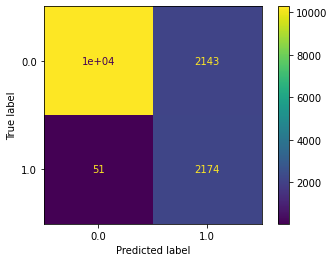

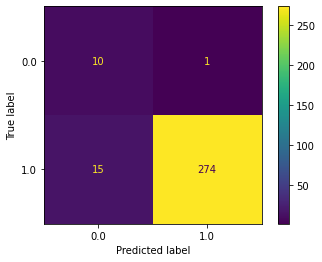

In [22]:
#Confusion Matrices

#Adult
cm_a = confusion_matrix(a_transf_test.labels, a_testset_pred_trans.labels)

disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a,
                              display_labels=trans_lr_a.classes_)
disp_a.plot() 

#German
cm_g = confusion_matrix(g_transf_test.labels, g_testset_pred_trans.labels)

disp_g = ConfusionMatrixDisplay(confusion_matrix=cm_g,
                              display_labels=trans_lr_g.classes_)
disp_g.plot() 

### In-processing algorithm: Adversarial Debiasing

### Fitting transformed dataset and Measuring Performance

In [ ]:
#the rest will be finished this weekend.

In [23]:
import tensorflow as tf
#This algorithm uses tensors

In [24]:
adv_deb.sess_.close()

NameError: name 'adv_deb' is not defined

#### Post-processing algorithm: Calibrated Equalized Odds

### Performance Comparison Among Mitigation Algorithms

#### Fairness Performance

#### Classifier Prediction Performance